<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle
import tensorflow_addons as tfa
import seaborn as sns
import pandas as pd
from sklearn import preprocessing


In [2]:
SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [4]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])

dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 33
decay_steps     = 2300
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]

def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)



def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [5]:
try:
    train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new.pkl'%label_),'rb'))
    print('data loaded from file')
except:
    train_data = np.load(os.path.join(root_model_data,'train_%s_new.npy.npz'%label_))
    valid_data = np.load(os.path.join(root_model_data,'valid_%s_new.npy.npz'%label_))
    test_data = np.load(os.path.join(root_model_data,'test_%s_new.npy.npz'%label_))


    keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DEC', 'class', 'subclass','SN','MJD','plate','fiber', 'mean', 'std')

    train = {}
    for item, key in zip(train_data.files, keys):
        train[key] = train_data[item]


    valid = {}
    for item, key in zip(valid_data.files, keys):
        valid[key] =  valid_data[item]

    test = {}
    for item, key in zip(test_data.files, keys):
        test[key] = test_data[item]


    le = sklearn.preprocessing.LabelEncoder()
    le.fit(train['subclass'])
    train['subclass'] = le.transform(train['subclass'])
    valid['subclass'] = le.transform(valid['subclass'])
    test['subclass']  = le.transform(test['subclass'])
    print(le.classes_, le.transform(le.classes_))        

    pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s_new.pkl'%label_),'wb'))


data loaded from file


In [6]:
Supernovas = pd.read_pickle('../forPub/Supernova_Sample.pkl')
df1 = pd.DataFrame()
df1['MJD']   = train['MJD']
df1['plate'] = train['plate']
df1['fiber'] = train['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))
df1 = pd.DataFrame()
df1['MJD']   = valid['MJD']
df1['plate'] = valid['plate']
df1['fiber'] = valid['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))
df1 = pd.DataFrame()
df1['MJD']   = test['MJD']
df1['plate'] = test['plate']
df1['fiber'] = test['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))

8
2
4


In [10]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 3
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    x = dense_block(x,out_features[ii])
    
x = dense_block(x,latent_dim,non_lin=False)
x = Reshape((latent_dim,1))(x)

for ii in range(n_layers-1):
    if conditional:
        x = dense_cond_block(x,z,out_features[-1-ii])
    else:
        x = dense_block(x,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
if conditional:
    x = dense_cond_block(x,z,dim, non_lin=False)
else:
    x = dense_block(x,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1000)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         1001000     flatten[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1000)         0           dense[0][0]                      
_______________________________________________________________________________________

In [11]:
path = os.path.join(root_models,'full_ae_model_%s_run%s_new'%(label_2,RUN))

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final validation reconstruction error:', np.sqrt(recon_error))


lstm_ae.save(path)

Epoch 1/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 2.8286
Epoch 2/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.5391
Epoch 3/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.4304
Epoch 4/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.3566
Epoch 5/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.3455
Epoch 6/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.3248
Epoch 7/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.3096
Epoch 8/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.2963
Epoch 9/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.2886
Epoch 10/40
8049/8049 [==============================] - 13s 2ms/step - training_loss: 1.2788
Epoch 11/40
8049/8049 [==============================] - 13s 2ms/step

In [12]:
for label in np.arange(8):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.1740875590205502
training:  1.1691406215531555
[b'AGN']
validation:  1.282758748936471
training:  1.280610300822296
[b'AGN BROADLINE']
validation:  1.6708591813108433
training:  1.500302838600689
[b'BROADLINE']
validation:  1.3288236546841155
training:  1.2732286179065084
[b'STARBURST']
validation:  1.3510237212756666
training:  1.3367912301728841
[b'STARBURST BROADLINE']
validation:  1.7301725299272805
training:  1.6324990479760113
[b'STARFORMING']
validation:  1.238647597409674
training:  1.2328753457550392
[b'STARFORMING BROADLINE']
validation:  1.2504889274654123
training:  1.2479288653776652


In [9]:
# def bootstrap(train_data, batch_size):
#     index   = np.arange(len(train['spec']))
#     metrics = []
#     for ii in range(1000):
#         sample    = np.random.choice(index, size=batch_size, replace=False, p=None)
#         res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
#         metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
#         metrics.append(metric)
#     return np.mean(metrics), np.std(metrics)

In [10]:
#bootstrap(train, batch_size=len(valid['spec']))

In [13]:
### concatenate and split input
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [14]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [15]:
encoder = extract_layers(lstm_ae,0,13)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aad2530b3d0>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad25784a30>
2 <tensorflow.python.keras.layers.core.Dense object at 0x2aad25784f40>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aad257aa7c0>
4 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad257aaa30>
5 <tensorflow.python.keras.layers.core.Dropout object at 0x2aad257aa580>
6 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad257da610>
7 <tensorflow.python.keras.layers.core.Dense object at 0x2aad26808a90>
8 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aaba8c2f4c0>
9 <tensorflow.python.keras.layers.core.Reshape object at 0x2aae24a6f220>
10 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad25784580>
11 <tensorflow.python.keras.layers.core.Dense object at 0x2aad26828190>
12 <tensorflow.python.keras.layers.core.Reshape object at 0x2aad26832a90>
Model: "

In [16]:
if conditional:
    decoder = extract_layers_base(lstm_ae,13,25)
    input      = Input(shape=(latent_dim,1))
    input_type = Input(shape=(1,1))
    print(decoder[0])
    x          = decoder[0]((input,input_type))
    for ii in range(1,len(decoder)):
        try:
            x = decoder[ii](x)
        except:
            x = decoder[ii]((x, input_type))
    decoder = Model((input,input_type),x)
else:
    decoder = extract_layers(lstm_ae,13,25)
    decoder.build((None,latent_dim,1))

13 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaaaeb98eb0>
14 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad26832d00>
15 <tensorflow.python.keras.layers.core.Dense object at 0x2aad26837a30>
16 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aaca6335d00>
17 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaca633eac0>
18 <tensorflow.python.keras.layers.core.Flatten object at 0x2aaca633e370>
19 <tensorflow.python.keras.layers.core.Dense object at 0x2aaca633e130>
20 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aaca6346eb0>
21 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaca634dc70>
22 <tensorflow.python.keras.layers.core.Dropout object at 0x2aaca634d8e0>
23 <tensorflow.python.keras.layers.core.Flatten object at 0x2aad26832520>
24 <tensorflow.python.keras.layers.core.Dense object at 0x2aaca6353460>


In [17]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 590)               6490      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 590)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 590, 1)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 590)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)             

In [18]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [19]:
if conditional:
    decoded_train  = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['subclass'],-1)))
    decoded_test   = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['subclass'],-1)))
    decoded_valid  = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['subclass'],-1)))
else:
    decoded_train  = decoder.predict(encoded_train)
    decoded_test   = decoder.predict(encoded_test)
    decoded_valid  = decoder.predict(encoded_valid)   

In [20]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_run1_new/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_run1_new/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_run1_new


In [21]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [22]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)

In [23]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)

In [24]:
np.save(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)),[decoded_train,decoded_valid, decoded_test, train['mean'], train['std']])

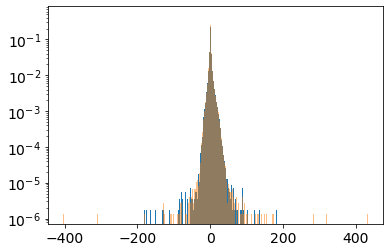

In [25]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

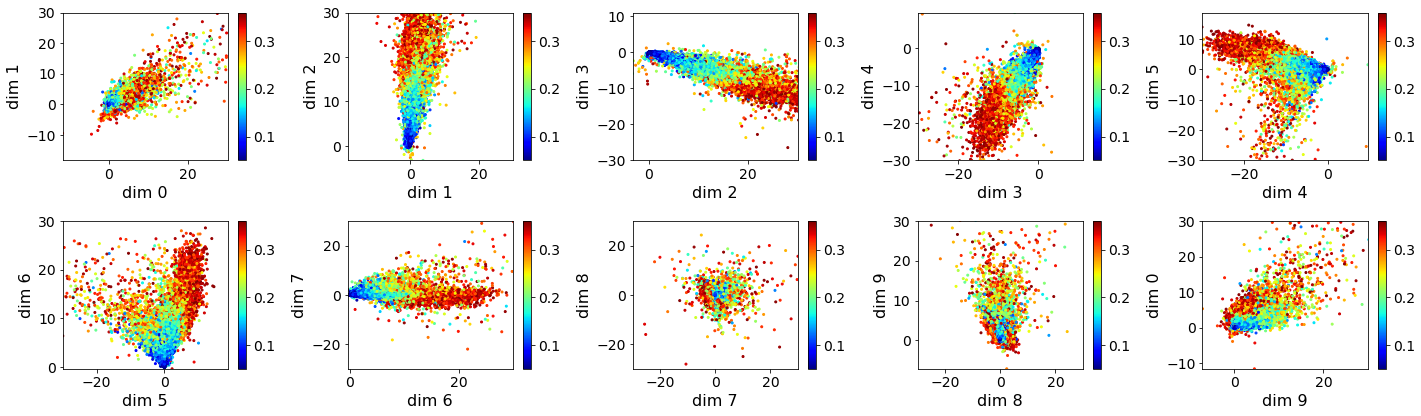

In [26]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_redshift_AE1.pdf'), bbox_inches='tight')
plt.show()


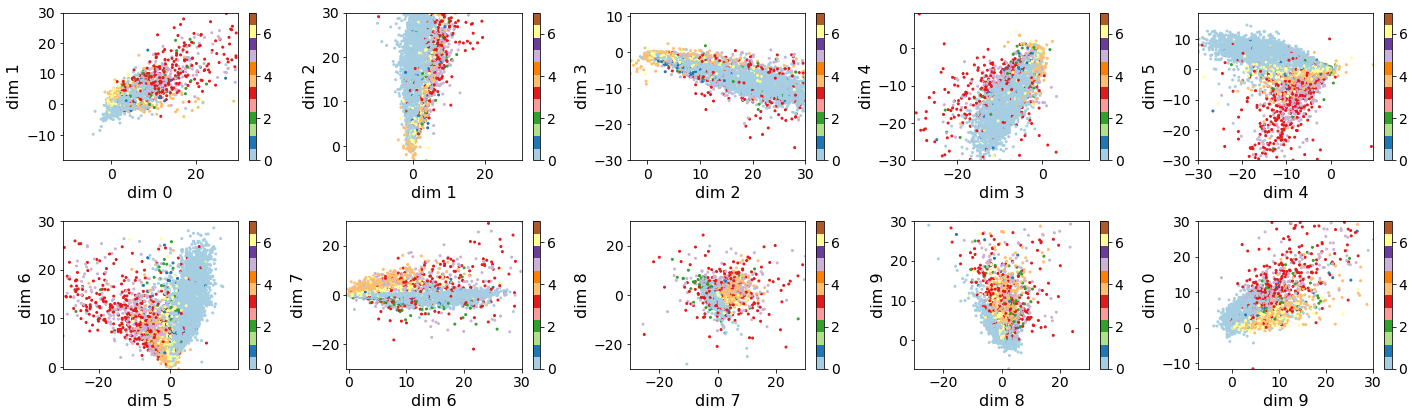

In [27]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='Paired', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_subclass_AE1.pdf'), bbox_inches='tight')
plt.show()


In [28]:
noise            = np.ma.array(np.squeeze(valid['noise']),mask=~np.squeeze(valid['mask'].astype('bool')))
recon_error      = np.ma.mean(np.ma.array(np.squeeze(valid['spec'])-decoded_valid,mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,axis=1)

Text(0.5, 0, '$\\chi^2$')

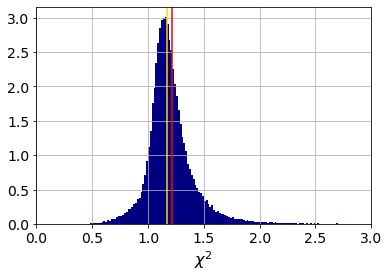

In [54]:
plt.hist(recon_error,bins=300,density=True,range=(0,5),color='navy')
plt.axvline(recon_error.mean(),color='red',label='mean')
plt.axvline(np.median(recon_error),color='gold',label='median')
plt.xlim(0,3)
plt.grid()
plt.xlabel(r'$\chi^2$')

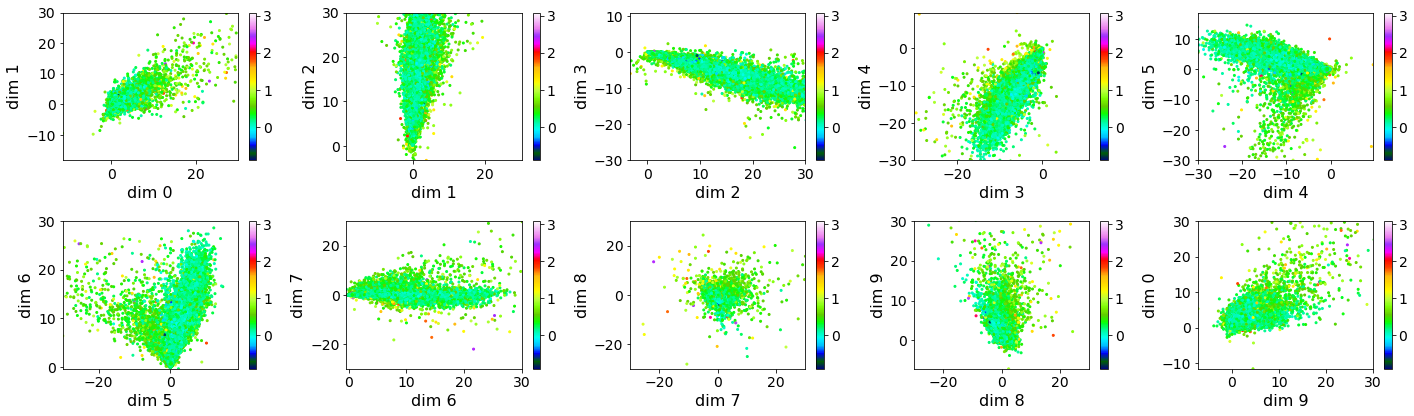

In [29]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=np.log(recon_error), cmap='gist_ncar', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_noise_AE1.pdf'), bbox_inches='tight')
plt.show()

In [30]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

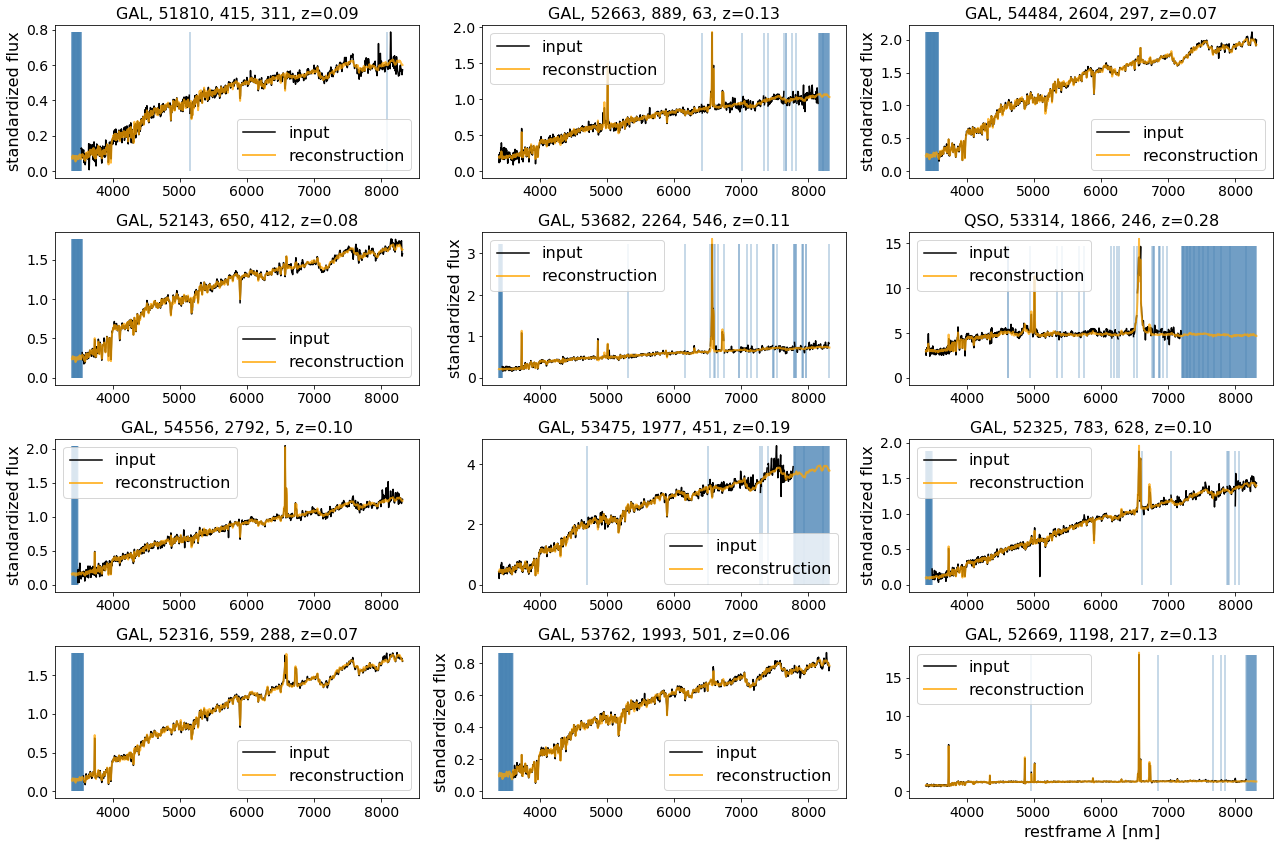

In [31]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(4,3,figsize=(18,12))
ax     = ax.flatten()
for ii in range(12):
    ind = (test['subclass']==(ii%7))
    ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ii]], test['MJD'][ind][ii],test['plate'][ind][ii],test['fiber'][ind][ii],test['z'][ind][ii]))
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],label='input', color='black')
    ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue',alpha=0.4)
    ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    ax[ii].legend()
    if ii in [11,12]:
        ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    if ii%2==0:
        ax[ii].set_ylabel(r'standardized flux')        
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1.pdf'), bbox_inches='tight')
plt.show()

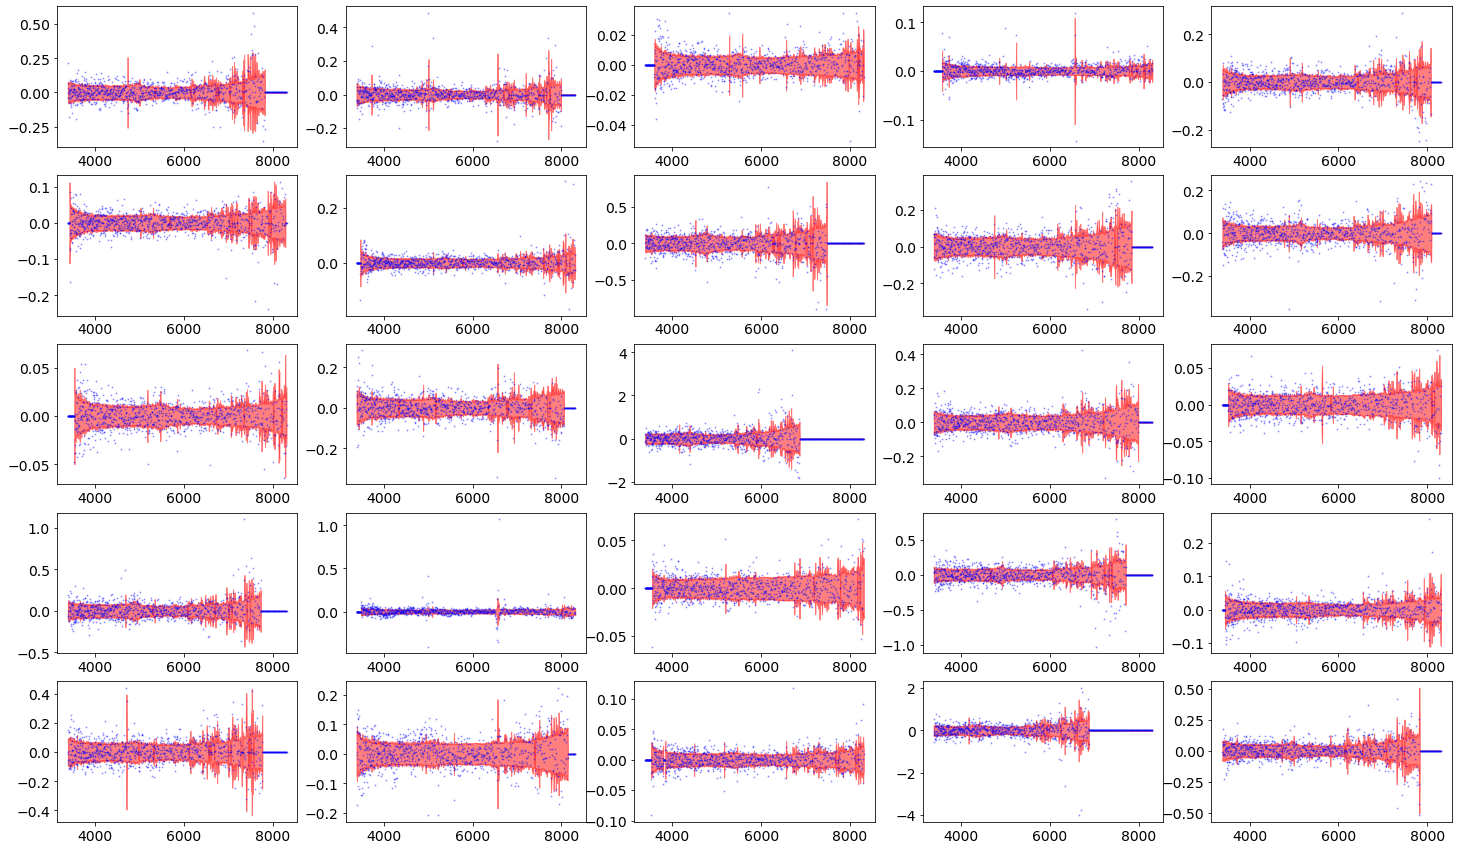

In [32]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [31]:
### Look at reconstruction ability as function of wavelength

In [33]:
def loss_by_wl(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [34]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

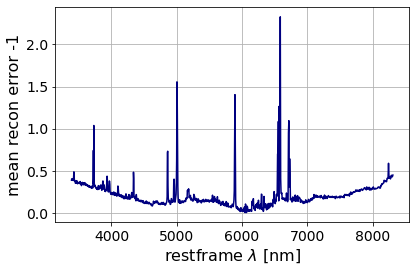

In [55]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0)-1,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('mean recon error -1')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_AE1.pdf'), bbox_inches='tight')

In [ ]:
## to do add chi2 plot
